# Chain-of-Thought Prompting

This notebook explains chain-of-thought (CoT) prompting in the context of large language models (LLMs). By the end, you'll know how to benchmark any LLM on any reasoning task that might benefit from CoT prompting. Hopefully this will also improve your intuition on how to use LLMs---like ChatGPT---more effectively.

## What is Chain-of-Thought Prompting?

In 2022, a group of Google researchers released this [paper](https://arxiv.org/pdf/2201.11903)

![CoT paper](./images/cot_paper.png)

which showed that including a series of intermediate reasoning steps in the prompt significantly improves the ability of LLMs to perform complex reasoning. They decided to call this series of intermediate reasoning steps a "chain-of-thought (CoT)." A brief demonstration of their findings is shown below.

One example of a complex reasoning task outlined in the paper is "arithmetic reasoning," which are essentially just math word problems.

Suppose we had the following question:

<div align="center", style="font-size:20px;">

*The cafeteria had 23 apples. If they used 20 to make lunch and bought 6 more, how many apples do they have?*

</div>

By doing some basic math, we can figure out that the answer is 23 - 20 + 6 = 9.

Let's see if an LLM can solve it.

The code below takes our question and asks it to GPT-3 using the OpenAI API.

Unlike LLMs like ChatGPT, which you might be more familiar using, the version of GPT-3 used in the original CoT paper has not been fine-tuned for human dialogue. In other words, it's not a chatbot. Instead, it'll take your prompt and continuously regurgitate the probabilistically most likely next word until you tell it to stop using the `max_tokens` parameter.

Thus, the reason why we include a `Q:`, `A:`, example before asking our question of interest, is to tell that model that we want it to respond in the format `A: <answer>`.

In [6]:
from dotenv import load_dotenv
import os
from openai import OpenAI
import matplotlib.pyplot as plt
from plotting import *

load_dotenv()
# Assumes you have an OpenAI API key in your .env file
api_key = os.getenv('API_KEY')
client = OpenAI(
    api_key=api_key
)

no_cot_prompt = """
Q: Roger has 5 tennis balls. He buys 2 more cans of tennis balls. Each can has 3 tennis balls. How many tennis balls does he have now?
A: The answer is 11.
Q: The cafeteria had 23 apples. If they used 20 to make lunch and bought 6 more, how many apples do they have?
"""

In [ ]:
# Run inference using GPT-3
response_no_cot = client.completions.create(
  model="davinci-002",
  prompt=no_cot_prompt,
  max_tokens=32,
  temperature=0
)
print(response_no_cot.choices[0].text.split('\n', 1)[0].strip())

Yikes... looks like GPT-3 is worse at math than your average elementary schooler. But all hope isn't lost yet. Let's try including a chain-of-thought in our example question.

In [ ]:
cot_prompt = """
Q: Roger has 5 tennis balls. He buys 2 more cans of tennis balls. Each can has 3 tennis balls. How many tennis balls does he have now?
A: Roger started with 5 balls. 2 cans of 3 tennis balls each is 6 tennis balls. 5 + 6 = 11. The answer is 11.
Q: The cafeteria had 23 apples. If they used 20 to make lunch and bought 6 more, how many apples do they have?
"""

response_cot = client.completions.create(
  model="davinci-002",
  prompt=cot_prompt,
  max_tokens=128,
  temperature=0
)
print(response_cot.choices[0].text.split('\n', 1)[0].strip())

Would you look at that. Looks like GPT-3 might be good at math after all.

This is a pretty shocking result: it seems like we're able to drastically improve an LLM's ability at basic logical reasoning by simply being a bit more thoughtful with our prompt.

Let's try to make this observation more rigorous.

## Evaluation

We'll evaluate 3 LLMs on 3 distinct reasoning tasks. The 3 LLMs are as follows
1. GPT-3 babbage-002 (< 1.3B parameters)
2. GPT-3 davinci-002 (< 175B parameters)
3. Apple's OpenELM (3B parameters)

The GPT-3 babbage-002 and davinci-002 LLMs are the closest models we have to the GTP-3 text-ada-001, text-babbage-001, text-curie-001, and text-davinci-002 LLMs used in the original CoT paper (Unfortunately, OpenAI has since deprecated all those models.) Apple's OpenELM model, on other other hand, is a brand new model from April 2024 that is (as far as we know) currently unbenchmarked on all the CoT reasoning tasks.

The categories of reasoning tasks are identical to the original CoT paper. They're
1. Arithmetic reasoning: math word problems like the one we showed above
    - We're specifcally using the [GSM-8K dataset](https://arxiv.org/abs/2110.14168)
2. Commonsense reasoning: yes or no questions about physical and human interactions under the presumption of general background knowledge.
    - We're specifically using the [StrategyQA dataset](https://arxiv.org/abs/2101.02235)
3. Symbolic reasoning: questions that ask the LLM to manipulate symbols
    - We randomly generated 1000 names and asked the LLM to manipulate the letters

Let's write some code to test these 3 types of reasoning problems

### Arithmetic Reasoning

An example problem from the GSM-8K dataset, along with a no CoT and CoT answer is shown below:

<div align="center", style="font-size:16px; text-align:left; max-width:80%;">

*Q: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?*

*A (No CoT): The answer is 5.*

*A (CoT): There are originally 3 cars. 2 more cars arrive. 3 + 2 = 5. The answer is 5.*

</div>

We'll start by loading the GSM-8K dataset and cleaning it up a little. Specifcally, we just want the `question` and `answer` columns, and the first 1000 entries.

In [3]:
import pandas as pd

gsm8k_df = pd.read_csv("./data/gsm8k_data.csv")
gsm8k_df = gsm8k_df[["question", "answer"]]
gsm8k_df = gsm8k_df[:1000]

,question,answer
0,Natalia sold clips to 48 of her friends in Apr...,Natalia sold 48/2 = <<48/2=24>>24 clips in May...
1,Weng earns $12 an hour for babysitting. Yester...,Weng earns 12/60 = $<<12/60=0.2>>0.2 per minut...
2,Betty is saving money for a new wallet which c...,"In the beginning, Betty has only 100 / 2 = $<<..."
3,"Julie is reading a 120-page book. Yesterday, s...",Maila read 12 x 2 = <<12*2=24>>24 pages today....
4,James writes a 3-page letter to 2 different fr...,He writes each friend 3*2=<<3*2=6>>6 pages a w...
...,...,...
995,"Josh and Anna were both born on August 17th, b...",We know that Josh must be 30 years older than ...
996,A club opens up and charges $20 to enter. Jam...,He buys 2*5=<<2*5=10>>10 drinks for his friend...
997,Ittymangnark and Kingnook are an Eskimo couple...,If the dog eats two eyes and Oomyapeck eats 22...
998,Lydia has a small pool she uses to bathe her d...,With a garden hose that fills at a rate of 1.6...


For our 2 base prompts (CoT and no CoT), we use the exact same prompt as the original Wei et al. paper. It consists of 8 example question-answer pairs from the GSM-8K dataset, and chain-of-thought reasoning manually written by the Google researchers.

In [4]:
gsm8k_no_cot_prompt = """
Q: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there will be 21 trees. How many trees did the grove workers plant today?
A: The answer is 6.
Q: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?
A: The answer is 5.
Q: Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?
A: The answer is 39.
Q: Jason had 20 lollipops. He gave Denny some lollipops. Now Jason has 12 lollipops. How many lollipops did Jason give to Denny?
A: The answer is 8.
Q: Shawn has five toys. For Christmas, he got two toys each from his mom and dad. How many toys does he have now?
A: The answer is 9.
Q: There were nine computers in the server room. Five more computers were installed each day, from monday to thursday. How many computers are now in the server room?
A: The answer is 29.
Q: Michael had 58 golf balls. On tuesday, he lost 23 golf balls. On wednesday, he lost 2 more. How many golf balls did he have at the end of wednesday?
A: The answer is 33.
Q: Olivia has $23. She bought five bagels for $3 each. How much money does she have left?
A: The answer is 8.
"""

gsm8k_cot_prompt = """
Q: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done, there will be 21 trees. How many trees did the grove workers plant today?
A: There are 15 trees originally. Then there were 21 trees after some more were planted. So there must have been 21 - 15 = 6. The answer is 6.
Q: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?
A: There are originally 3 cars. 2 more cars arrive. 3 + 2 = 5. The answer is 5.
Q: Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?
A: Originally, Leah had 32 chocolates. Her sister had 42. So in total they had 32 + 42 = 74. After eating 35, they had 74 - 35 = 39. The answer is 39.
Q: Jason had 20 lollipops. He gave Denny some lollipops. Now Jason has 12 lollipops. How many lollipops did Jason give to Denny?
A: Jason started with 20 lollipops. Then he had 12 after giving some to Denny. So he gave Denny 20 - 12 = 8. The answer is 8.
Q: Shawn has five toys. For Christmas, he got two toys each from his mom and dad. How many toys does he have now?
A: Shawn started with 5 toys. If he got 2 toys each from his mom and dad, then that is 4 more toys. 5 + 4 = 9. The answer is 9.
Q: There were nine computers in the server room. Five more computers were installed each day, from monday to thursday. How many computers are now in the server room?
A: There were originally 9 computers. For each of 4 days, 5 more computers were added. So 5 * 4 = 20 computers were added. 9 + 20 is 29. The answer is 29.
Q: Michael had 58 golf balls. On tuesday, he lost 23 golf balls. On wednesday, he lost 2 more. How many golf balls did he have at the end of wednesday?
A: Michael started with 58 golf balls. After losing 23 on tuesday, he had 58 - 23 = 35. After losing 2 more, he had 35 - 2 = 33 golf balls. The answer is 33.
Q: Olivia has $23. She bought five bagels for $3 each. How much money does she have left?
A: Olivia had 23 dollars. 5 bagels for 3 dollars each will be 5 x 3 = 15 dollars. So she has 23 - 15 dollars left. 23 - 15 is 8. The answer is 8.
"""

Next, we'll write a generic `generate_response` function thats asks an OpenAI model a user-specified prompt. The code at the end just extracts the answer from the `completions` object returned by the OpenAI API and removes any extra text generated by the model after answering the question. We'll reuse this function for the other 2 reasoning tasks as well.

In [ ]:
def generate_response(question, base_prompt, model):
    prompt = base_prompt + "Q: " + question + "\n"
    response = client.completions.create(
        model=model,
        prompt=prompt,
        max_tokens=256,
        temperature=0.3
    )
    return response.choices[0].text.split('\n', 1)[0].strip()

Finally, we'll generate responses for all 1000 questions in our dataframe using GPT-3 babbage-002 and davinci-002 with both no CoT and CoT. We'll store the model responses in the same dataframe.

In [ ]:
# Generate no cot reponses for gsm8k with babbage
gsm8k_df['babbage_no_cot'] = gsm8k_df['question'].apply(lambda q: generate_response(q, gsm8k_no_cot_prompt, "babbage-002"))

In [ ]:
# Generate cot responses for gsm8k with babbage
gsm8k_df['babbage_cot'] = gsm8k_df['question'].apply(lambda q: generate_response(q, gsm8k_cot_prompt, "babbage-002"))

In [ ]:
# Generate no cot responses for gsm8k with davinci
gsm8k_df['davinci_no_cot'] = gsm8k_df['question'].apply(lambda q: generate_response(q, gsm8k_no_cot_prompt, "davinci-002"))

In [ ]:
# Generate cot responses for gsm8k with davinci
gsm8k_df['davinci_cot'] = gsm8k_df['question'].apply(lambda q: generate_response(q, gsm8k_cot_prompt, "davinci-002"))

For Apple's OpenELM, we perform a very similar process. However, instead of using the OpenAI API, we load the model and perform inference locally. The code can be found in the `openelm_gsm8k.py` file. You can test a different model other than OpenELM by simply changing the model name using the Hugging Face API.

Finally, we compute the accuracy for all 3 models on the GSM-8K dataset in the `compute_accuracy_gpt_gsm8k.ipynb` and `compute_accuracy_openelm_gsm8k.ipynb` notebooks. And generate a plot in `plotting.py`. The final result is shown below.

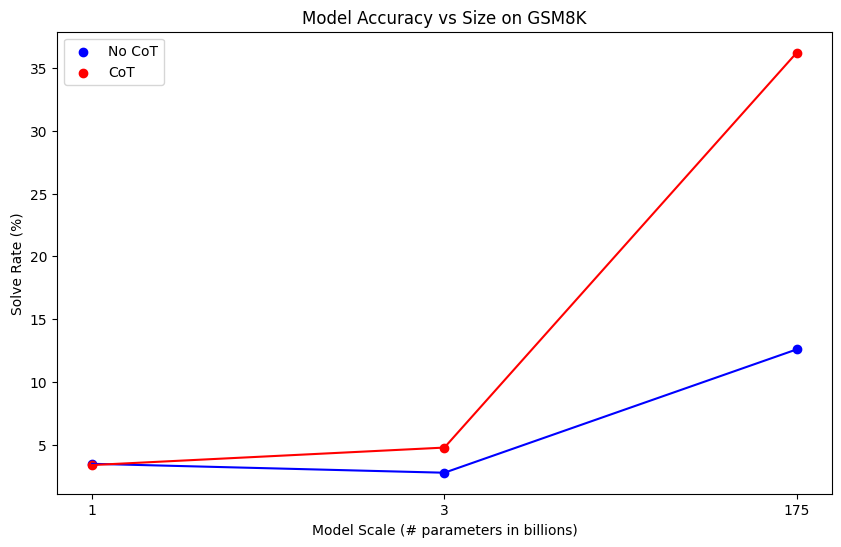

In [7]:
plot_gsm8k()

Would you look at that! It looks like model performance on math word problems improves signiicantly with CoT, especially on the larger parameter models. This data supports our one quesstion example from the start of the notebook.

Let's try a different type of reasoning task now. 

### Commonsense Reasoning

An example question from the StrategyQA dataset, along with a no CoT and CoT answer is shown below:

<div align="center", style="font-size:16px; text-align:left; max-width:80%;">

*Q: Do hamsters provide food for any animals?*

*A (No CoT): Yes*

*A (CoT): Hamsters are prey animals. Prey are food for predators. Thus, hamsters provide food for some animals. So the answer is yes.*

</div>

Again, we'll start by loading the StrategyQA dataset and doing some preprocessing.

In [9]:
stratqa_df = pd.read_csv("data/strategyqa.csv")
stratqa_df = stratqa_df[:1000]
stratqa_df

,question,answer
0,Are more people today related to Genghis Khan ...,yes
1,Could the members of The Police perform lawful...,no
2,Would a Monoamine Oxidase candy bar cheer up a...,no
3,Would a dog respond to bell before Grey seal?,yes
4,Is a pound sterling valuable?,no
...,...,...
995,Would a Gray Whale fit easily in an above grou...,no
996,Do you need lactobacillus to make pickles?,no
997,Did Holy Saturday 2019 have special significan...,yes
998,Did people in Korea under Japanese Rule watch ...,no


Use the same no CoT and CoT base prompts as the original Wei et. al paper

In [10]:
stratqa_no_cot_prompt = """
Q: Do hamsters provide food for any animals?
A: So the answer is yes.
Q: Could Brooke Shields succeed at University of Pennsylvania?
A: So the answer is yes.
Q: Yes or no: Hydrogen's atomic number squared exceeds number of Spice Girls?
A: So the answer is no.
Q: Yes or no: Is it common to see frost during some college commencements?
A: So the answer is yes.
Q: Yes or no: Could a llama birth twice during War in Vietnam (1945-46)?
A: So the answer is no.
Q: Yes or no: Would a pear sink in water?
A: So the answer is no.
"""

stratqa_cot_prompt = """
Q: Do hamsters provide food for any animals?
A: Hamsters are prey animals. Prey are food for predators. Thus, hamsters provide food for some animals. So the answer is yes.
Q: Could Brooke Shields succeed at University of Pennsylvania?
A: Brooke Shields went to Princeton University. Princeton University is about as academically rigorous as the University of Pennsylvania. Thus, Brooke Shields could also succeed at the University of Pennsylvania. So the answer is yes.
Q: Yes or no: Hydrogen's atomic number squared exceeds number of Spice Girls?
A: Hydrogen has an atomic number of 1. 1 squared is 1. There are 5 Spice Girls. Thus, Hydrogen’s atomic number squared is less than 5. So the answer is no.
Q: Yes or no: Is it common to see frost during some college commencements?
A: College commencement ceremonies can happen in December, May, and June. December is in the winter, so there can be frost. Thus, there could be frost at some commencements. So the answer is yes.
Q: Yes or no: Could a llama birth twice during War in Vietnam (1945-46)?
A: The War in Vietnam was 6 months. The gestation period for a llama is 11 months, which is more than 6 months. Thus, a llama could not give birth twice during the War in Vietnam. So the answer is no.
Q: Yes or no: Would a pear sink in water?
A: The density of a pear is about 0.6g/cm^3, which is less than water. Objects less dense than water float. Thus, a pear would float. So the answer is no.
"""

And generate both no CoT and CoT responses with GPT-3 babbage-002 and davinci-002

In [ ]:
# Generate no cot reponses for strategyqa with babbage
stratqa_df['babbage_no_cot'] = stratqa_df['question'].apply(lambda q: generate_response(q, stratqa_no_cot_prompt, "babbage-002"))

In [ ]:
# Generate cot reponses for strategyqa with babbage
stratqa_df['babbage_cot'] = stratqa_df['question'].apply(lambda q: generate_response(q, stratqa_cot_prompt, "babbage-002"))

In [ ]:
# Generate no cot reponses for strategyqa with davinci
stratqa_df['davinci_no_cot'] = stratqa_df['question'].apply(lambda q: generate_response(q, stratqa_no_cot_prompt, "davinci-002"))

In [ ]:
# Generate cot reponses for strategyqa with davinci
stratqa_df['davinci_cot'] = stratqa_df['question'].apply(lambda q: generate_response(q, stratqa_cot_prompt, "davinci-002"))

The code for running inference using Apple's OpenELM can be found in `openelm_strategyqa.py`. We also compute model accuracies in `compute_accuracy_gpt_strategyqa.ipynb` and `compute_accuracy_openelm_strategyqa.ipynb` to create the following graph:

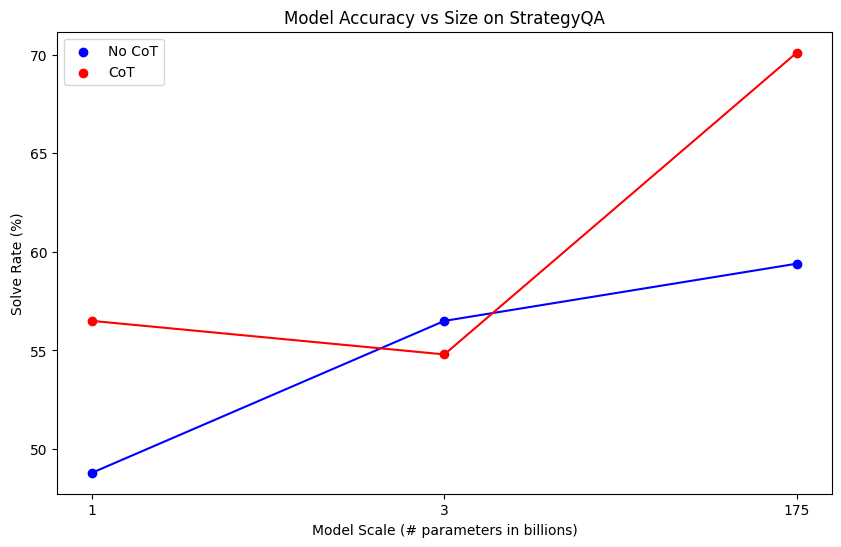

In [11]:
plot_stratqa()

The results are a bit more mixed than with math word problems, particularly with OpenELM, where no CoT performs better than CoT (although it's close). As a reminder, StrategyQA is all "yes" or "no" questions, so 50% is actually our baseline accuracy.

However, our biggest 175B parameter GPT-3 davinci-002 model still improved significantly with CoT. Perhaps CoT reasoning is an emergent ability that improves with increased model scale?

Let's try analyzing one more reasoning task.

### Symbolic Reasoning

To test symbolic reasoning, we randomly generated 1000 names and asked the model to concat the last letter of each word in the name. 500 of these names consist of 2 words and 500 consist of 4 words. We'll explain why in a second.

An example question, along with a no CoT and CoT answer is shown below:

<div align="center", style="font-size:16px; text-align:left; max-width:80%;">

*Q: Take the last letters of the words in "Elon Musk" and concatenate them.*

*A (No CoT): The answer is nk.*

*A (CoT): The last letter of "Elon" is "n". The last letter of "Musk" is "k". Concatenating them is "nk". The answer is nk*

</div>

Lets load in the datasets one last time.

In [14]:
names_df = pd.read_csv("data/Random Names.csv")
names_OOD_df = pd.read_csv("data/Random Names OOD.csv")
names_df

,Name,Answer
0,SHEILA PUCKETT,AT
1,TAMMY ZAMORA,YA
2,PEARL DICKERSON,LN
3,EVA AYALA,AA
4,DANIELLE SANFORD,ED
...,...,...
495,MARIE RAMOS,ES
496,CARLA HOGAN,AN
497,STEVE ODOM,EM
498,ALBERTO CUNNINGHAM,OM


In [13]:
names_OOD_df

,Name,Answer
0,CRAIG GUY STACY SANTANA,GYYA
1,GERALD MCKNIGHT KATRINA CARPENTER,DTAR
2,LOIS JACKSON BRENDA SHAW,SNAW
3,DEBORAH JONES CAROL CAIN,HSLN
4,MARCUS DOMINGUEZ JESSE SEXTON,SZEN
...,...,...
495,LISA DRAKE TAMARA SCHNEIDER,AEAR
496,ANTONIO FRANKS TERRY BLEVINS,OSYS
497,ANTHONY HUGHES IRENE RAY,YSEY
498,ROLAND KERR SHERRY BOYER,DRYR


Along with the base prompts used by Wei et al.

In [15]:
names_cot_prompt = """
Q: Take the last letters of the words in "Elon Musk" and concatenate them.
A: The last letter of "Elon" is "n". The last letter of "Musk" is "k". Concatenating them is "nk". The answer is nk.
Q: Take the last letters of the words in "Larry Page" and concatenate them.
A: The last letter of "Larry" is "y". The last letter of "Page" is "e". Concatenating them is "ye". The answer is ye.
Q: Take the last letters of the words in "Sergey Brin" and concatenate them.
A: The last letter of "Sergey" is "y". The last letter of "Brin" is "n". Concatenating them is "yn". The answer is yn.
Q: Take the last letters of the words in "Bill Gates" and concatenate them.
A: The last letter of "Bill" is "l". The last letter of "Gates" is "s". Concatenating them is "ls". The answer is ls.
"""

names_no_cot_prompt = """
Q: Take the last letters of the words in "Elon Musk" and concatenate them.
A: The answer is nk.
Q: Take the last letters of the words in "Larry Page" and concatenate them.
A: The answer is ye.
Q: Take the last letters of the words in "Sergey Brin" and concatenate them.
A: The answer is yn.
Q: Take the last letters of the words in "Bill Gates" and concatenate them.
A: The answer is ls.
"""

Since the examples in our prompts deterministically tell the model how to solve this task for 2 word names, we create a second out-of-domain (OOD) dataset consisting of 4 words names to see how well the model generalizes. Put differently, we want to make sure our model's reasoning abilities have improved, and not that it's just learned how to do one very niche task from the prompt.

We'll perform some more data preprocessing so we can use our same trusty `generate_response` function from the beginning

In [16]:
def convert_name_to_question(name):
    return f"Take the last letters of the words in “{name}” and concatenate them."

In [17]:
names_df.rename(columns={'Name': 'question'}, inplace=True)
names_df.rename(columns={'Answer': 'answer'}, inplace=True)

names_OOD_df.rename(columns={'Name': 'question'}, inplace=True)
names_OOD_df.rename(columns={'Answer': 'answer'}, inplace=True)

names_df['question'] = names_df['question'].apply(convert_name_to_question)
names_OOD_df['question'] = names_OOD_df['question'].apply(convert_name_to_question)

And now we're ready to do inference using GPT-3 again

In [ ]:
# Generate no cot reponses for in domain names with babbage
names_df['babbage_no_cot'] = names_df['question'].apply(lambda q: generate_response(q, names_no_cot_prompt, "babbage-002"))

In [ ]:
# Generate cot reponses for in domain names with babbage
names_df['babbage_cot'] = names_df['question'].apply(lambda q: generate_response(q, names_cot_prompt, "babbage-002"))

In [ ]:
# Generate no cot reponses for in domain names with davinci
names_df['davinci_no_cot'] = names_df['question'].apply(lambda q: generate_response(q, names_no_cot_prompt, "davinci-002"))

In [ ]:
# Generate cot reponses for in domain names with davinci
names_df['davinci_cot'] = names_df['question'].apply(lambda q: generate_response(q, names_cot_prompt, "davinci-002"))

In [ ]:
# Generate no cot reponses for out of domain names with babbage
names_OOD_df['babbage_no_cot'] = names_OOD_df['question'].apply(lambda q: generate_response(q, names_no_cot_prompt, "babbage-002"))

In [ ]:
# Generate cot reponses for out of domain names with babbage
names_OOD_df['babbage_cot'] = names_OOD_df['question'].apply(lambda q: generate_response(q, names_cot_prompt, "babbage-002"))

In [ ]:
# Generate no cot reponses for out of domain names with davinci
names_OOD_df['davinci_no_cot'] = names_OOD_df['question'].apply(lambda q: generate_response(q, names_no_cot_prompt, "davinci-002"))

In [ ]:
# Generate cot reponses for out of domain names with davinci
names_OOD_df['davinci_cot'] = names_OOD_df['question'].apply(lambda q: generate_response(q, names_cot_prompt, "davinci-002"))

Like before, the code for doing inference with OpenELM is in `openelm_in_domain.py` and `openelm_out_domain.py`. The code for computing accuracies can also be found in the `compute_accuracy` folder.

Here are our results:

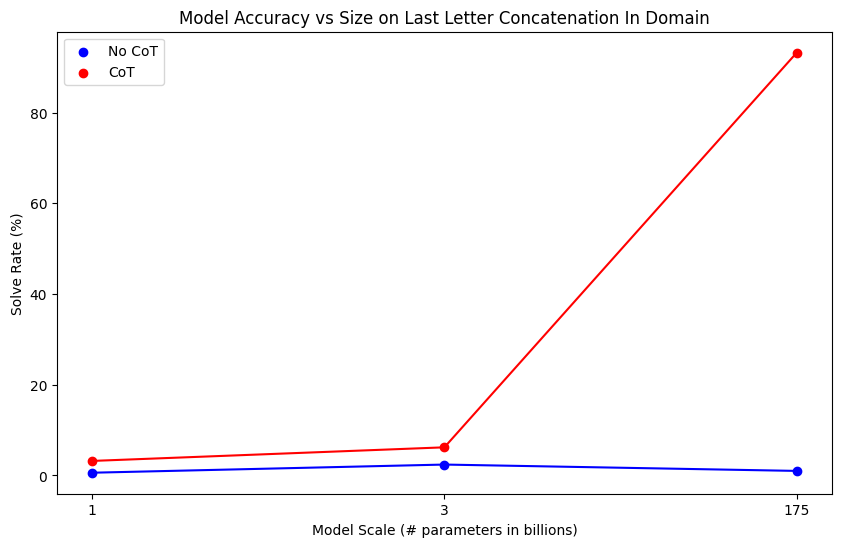

In [18]:
plot_in_domain()

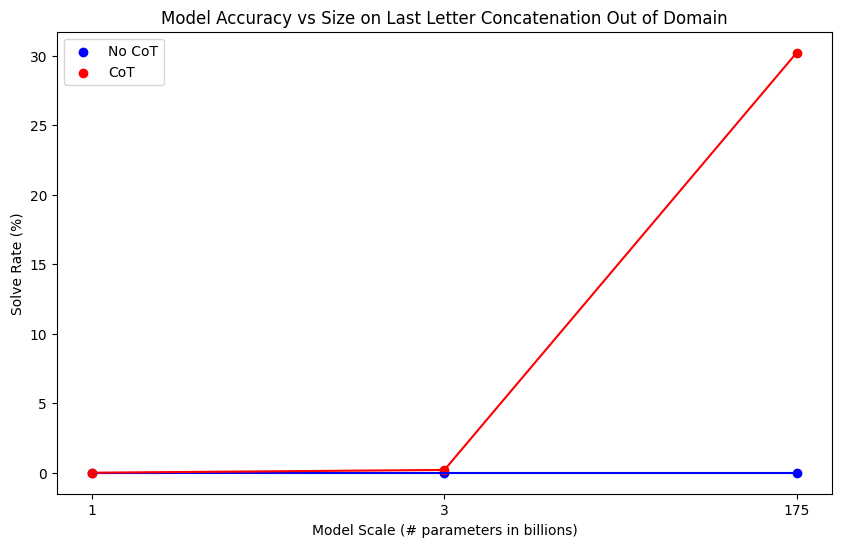

In [19]:
plot_out_domain()

This might be our most interesting result yet. Last letter concatenation seems to be a skill that's completely absent in all models without CoT. However, if we add CoT, althought the smaller 1B and 3B parameter models still peform quite poorly, our biggest 175B model achieves near perfect accuracy in the in-domain 2 letter concatentaion, and a very respectable 30% accuracy in the out-of-domain 4 letter concatenation.

Who would've thought CoT could be so impactful?

## Conclusion

Based on these results, it seems like you can significantly improve an LLM's ability to solve reasoning tasks by simply being a bit more thoughtful about your prompt.

Furthemermore, one of the lasting impacts of the original CoT paper, is that the GSM-8K dataset is now a standard benchmark used by all tech companies whenever they launch a new LLM. For example, here's Meta's new Llama 3 they released a few weeks ago:

![Llama 3 Benchmarks](./images/llama_benchmarks.png)

And now you all know how to compute this exact benchmark.

*Note: our working theory for why Apple decided to leave their OpenELM model unbenchmarked on GSM-8K is because it sucks on it.*

However, we'd be remiss not to mention some limitations with CoT that've appeared since the original paper in 2022.

First, although CoT's ability to improve model performance on reasoning tasks has been generally undisputed since the original Google research paper came out, there have been some [papers](https://arxiv.org/abs/2305.04388) that question our ability to make any interpretability statements from CoT reasoning. The paper we've linked above, for example, finds that if you have a reasoning task with multiple choice answers, and you rearrange your example answers to all be 'A', then the model will say the answer to any new question is also 'A' with high probability, and make up a CoT to support it. In other words, it's unclear whether or not the model is actually displaying any reasoning ability in its CoT: it could just be making stuff up.

Second, recent [papers](https://arxiv.org/pdf/2405.00332) have found that new models are overfit on benchmarks like GSM-8K because theyre likely in the training data (the biggest LLMs are trained on the whole internet). Although this doesn't directly undermine the perceived benefits of CoT, it's certainly worth noting.

That's it for now! Hopefully this notebook served as a comprehensive introduction to chain-of-thought prompting and improved your intuition on how to best use LLMs.